In [27]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from common.preprocessor import load_data, mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [237]:
data = pd.read_csv('Modified Data.csv',parse_dates=True, index_col=[0])

In [238]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


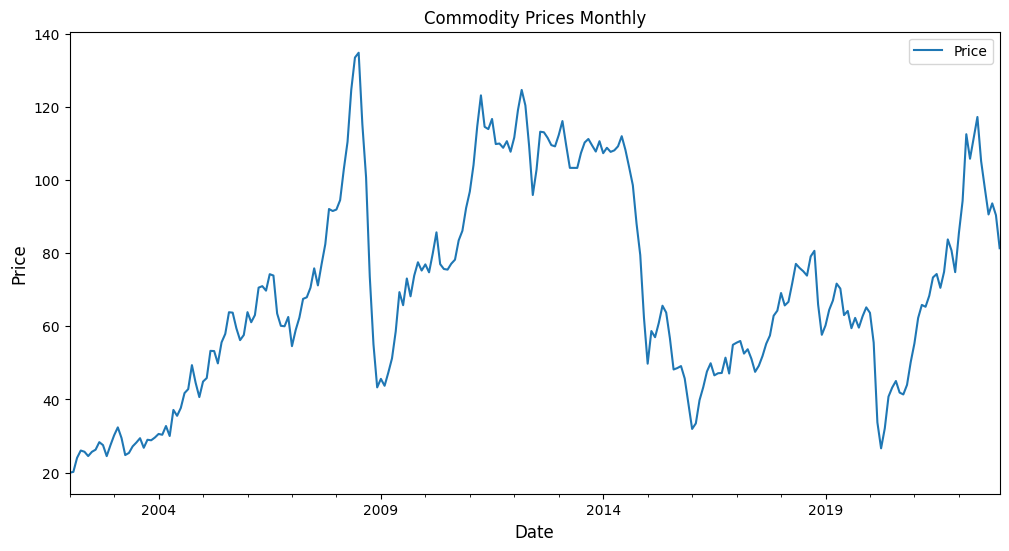

In [239]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [240]:
#create training and testing datasets
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [241]:
train.shape, test.shape

((201, 1), (51, 1))

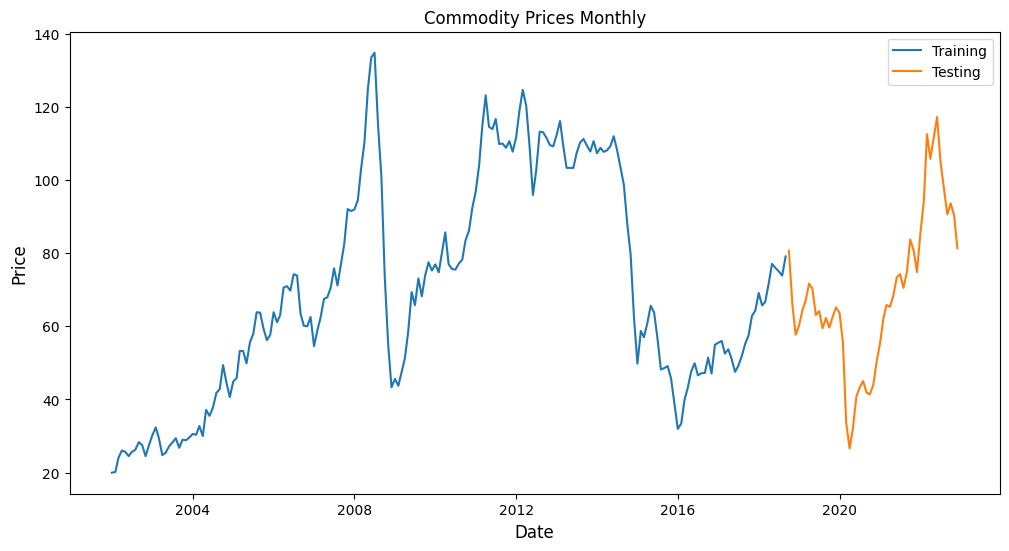

In [242]:
# visualize the training and testing datasets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

In [243]:
# scaled_train = train.copy() # use a copy fo the train dataset
# scaled_train = pd.DataFrame(scaled_train, columns=train.columns)
# scaled_train.head()

In [244]:
# # apply MinMaxScaler to the training dataset
# scaler = MinMaxScaler()
# scaler.fit(scaled_train)
# scaled_train = scaler.transform(scaled_train)
# scaled_train.head()

In [245]:
# scaled_test = test.copy() # use a copy of the test dataset
# scaled_test = pd.DataFrame(scaled_test, columns=test.columns)
# scaled_test.head()

In [246]:
# prepare data for training
scaler = MinMaxScaler()
train['Price'] = scaler.fit_transform(train[['Price']])
train.head()

,Price
2002-01-01,0.00
2002-02-01,0.00
2002-03-01,0.04
2002-04-01,0.05
2002-05-01,0.05


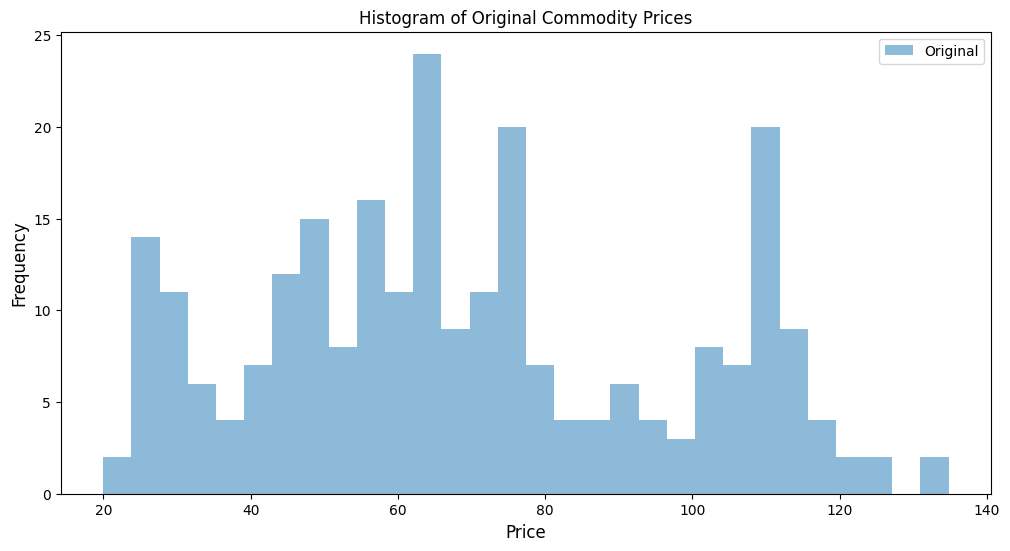

In [247]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.hist(data['Price'], bins=30, alpha=0.5, label='Original')
plt.title('Histogram of Original Commodity Prices')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

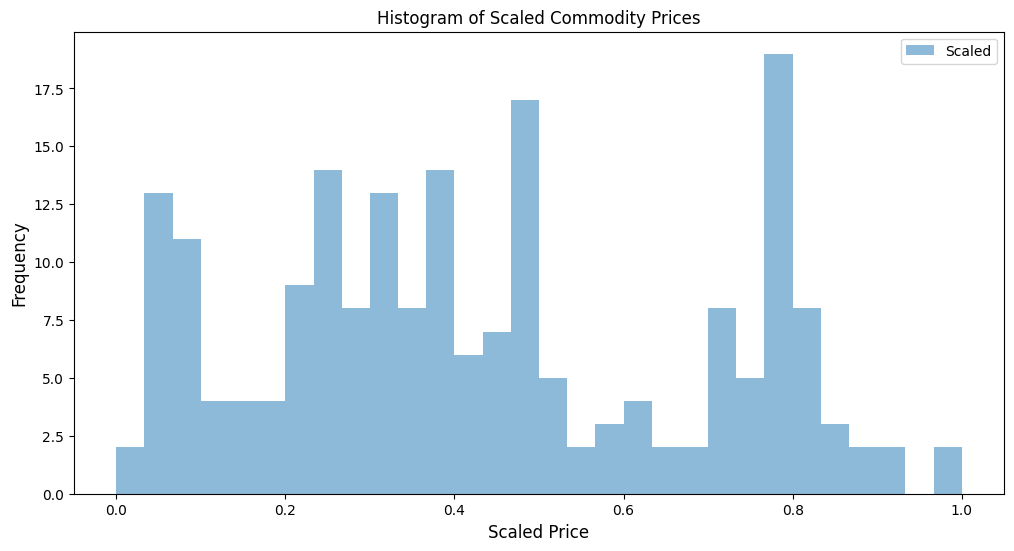

In [248]:
# Plot scaled data
plt.figure(figsize=(12, 6))
plt.hist(train['Price'], bins=30, alpha=0.5, label='Scaled')
plt.title('Histogram of Scaled Commodity Prices')
plt.xlabel('Scaled Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

In [249]:
# scale test data
test['Price'] = scaler.transform(test[['Price']])
test.head()

,Price
2018-10-01,0.53
2018-11-01,0.40
2018-12-01,0.33
2019-01-01,0.35
2019-02-01,0.39


In [250]:
#check to see if data is stationary
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'No. of lags used: {result[2]}')
    print(f'No. of observations used: {result[3]}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(train['Price'])

ADF Statistic: -2.4610076050408614
p-value: 0.1252520709317187
No. of lags used: 1
No. of observations used: 199
Critical Values:
   1%: -3.4636447617687436
   5%: -2.8761761179270766
   10%: -2.57457158581854
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [251]:
adf_test(test['Price'])

ADF Statistic: -1.5490837254384264
p-value: 0.5091058548155425
No. of lags used: 1
No. of observations used: 49
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [252]:
# Assuming `data` is your time series data
n_diffs = pm.arima.ndiffs(train['Price'], test='adf')  # 'adf' for Augmented Dickey-Fuller test

print(f"Number of differences required: {n_diffs}")

Number of differences required: 1


In [253]:
# Assuming `data` is your time series data
n_diffs = pm.arima.ndiffs(test['Price'], test='adf')  # 'adf' for Augmented Dickey-Fuller test

print(f"Number of differences required: {n_diffs}")

Number of differences required: 2


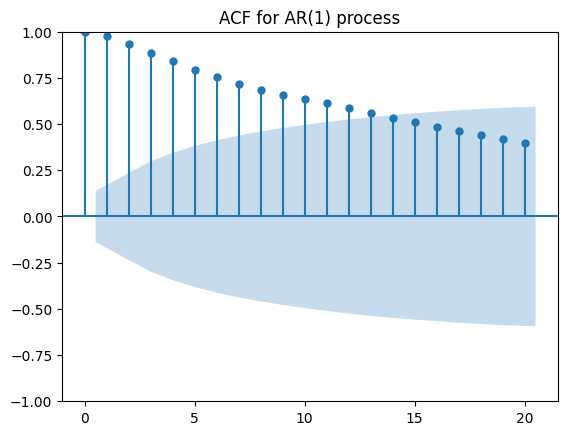

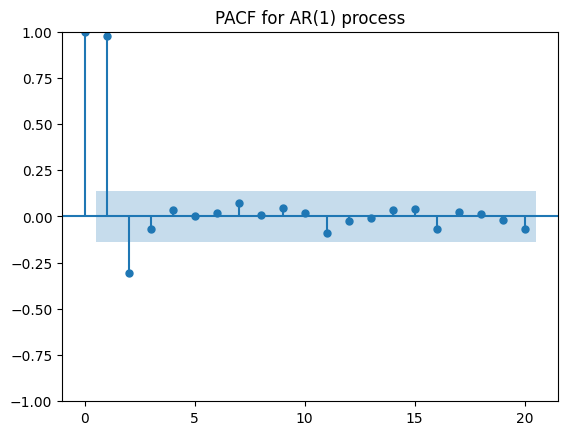

In [254]:
# acf and pacf plots for ar(1) and ma(1) processes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# AR(1) process
plot_acf(train['Price'], lags=20, title='ACF for AR(1) process')
plt.show()
plot_pacf(train['Price'], lags=20, title='PACF for AR(1) process')
plt.show()


In [255]:
# use auto arima to find the best parameters for training
model = auto_arima(train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-468.903, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-527.661, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-501.630, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-552.531, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-520.836, Time=0.49 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-550.995, Time=0.80 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-550.837, Time=1.12 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-544.683, Time=0.58 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-548.736, Time=1.50 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-550.543, Time=1.11 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

In [256]:
# use auto arima to find the best parameters for testing
model = auto_arima(test['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-80.776, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-76.456, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-81.711, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-82.175, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-81.658, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-81.272, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-79.286, Time=0.21 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-81.692, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-82.554, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-81.993, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,2)[12]      

In [257]:
# First difference
train_diff = train.diff().dropna()
train_diff.head()

,Price
2002-02-01,0.00
2002-03-01,0.03
2002-04-01,0.02
2002-05-01,-0.00
2002-06-01,-0.01


In [258]:
# Seasonal difference
# Assuming the seasonality is 12 (e.g., for monthly data), adjust as necessary
train_seasonal_diff = train_diff.diff(12).dropna()
train_seasonal_diff.head()

,Price
2003-02-01,0.02
2003-03-01,-0.06
2003-04-01,-0.06
2003-05-01,0.01
2003-06-01,0.03


In [259]:
# Do the same for the test set
test_diff = test.diff().dropna()
test_diff.head()

,Price
2018-11-01,-0.13
2018-12-01,-0.07
2019-01-01,0.02
2019-02-01,0.04
2019-03-01,0.02


In [260]:
test_seasonal_diff = test_diff.diff(12).dropna()
test_seasonal_diff.head()

,Price
2019-11-01,0.15
2019-12-01,0.09
2020-01-01,-0.04
2020-02-01,-0.11
2020-03-01,-0.21


In [261]:
# use auto arima to find the best parameters
model = auto_arima(train_seasonal_diff, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.fit(train_seasonal_diff)

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-227.514, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-307.509, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-249.867, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-349.125, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-326.501, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-349.846, Time=0.60 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-308.588, Time=0.25 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-357.965, Time=0.69 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-312.959, Time=0.34 sec
 ARIMA(3,1,0)(2,1,1)[12] 

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [262]:
# use auto arima to find the best parameters
model = auto_arima(test_seasonal_diff, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.fit(test_seasonal_diff)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-25.459, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-25.426, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-27.411, Time=0.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-25.553, Time=0.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-25.426, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-23.426, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=-25.560, Time=0.27 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 3.968 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [263]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_seasonal_diff, order=(3,1,1), seasonal_order=(2,1,0,12), freq="MS")
model_fit = model.fit(disp=0) # disp=0 to suppress convergence output to avoid clutter in the notebook

In [264]:
# Make predictions on the differenced seasonal test dataset.
predictions = model_fit.forecast(steps=len(test_seasonal_diff))

# Reverse the seasonal differencing.
predictions_diff = pd.Series(predictions, index=test_seasonal_diff.index)
predictions_seasonal = pd.Series(test_diff.iloc[0], index=test_diff.index)
predictions_seasonal = predictions_seasonal.add(predictions_diff, fill_value=0).fillna(0)

# Reverse the first differencing.
predictions = pd.Series(test.iloc[0], index=test.index)
predictions = predictions.add(predictions_seasonal.cumsum(), fill_value=0).fillna(0)

# Reverse the scaling.
predictions = scaler.inverse_transform(predictions.values.reshape(-1, 1))

# Convert the predictions to a Series.
predictions = pd.Series(predictions.flatten(), index=test.index)

In [265]:
test.head()

,Price
2018-10-01,0.53
2018-11-01,0.40
2018-12-01,0.33
2019-01-01,0.35
2019-02-01,0.39


In [266]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate the MSE
mse = mean_squared_error(test, predictions)
print(f'MSE: {mse}')


MSE: 3578.6488037365043


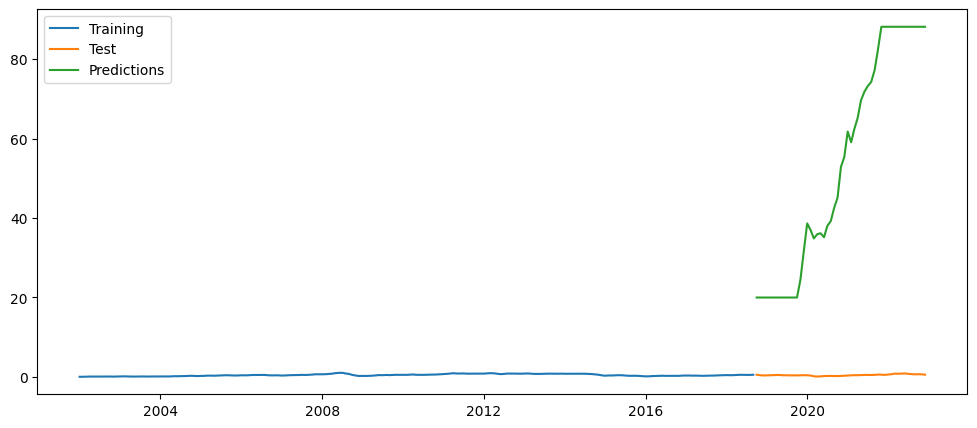

In [267]:
# Plot the results
plt.figure(figsize=(12,5))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()